In [1]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [2]:
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime

In [3]:
# Load JSON data from file
with open("/content/drive/MyDrive/SmartFactory/Dataset/factory_sensor_data.json", 'r') as f:
    data = json.load(f)

In [4]:
# Convert to DataFrame
df = pd.DataFrame(data)

In [5]:
df.head()

,timestamp,machine_id,temperature,vibration,rpm,pressure,humidity,voltage,failure
0,2024-08-07T21:16:54.644050,C-38K,79.18,0.74,2660,7.25,69.39,244.61,0
1,2022-08-15T02:09:25.644050,S-UCN,72.43,1.08,3028,5.26,40.82,247.73,0
2,2018-08-01T11:20:29.644050,T-T49,90.96,1.05,2846,3.12,45.49,236.86,0
3,2016-04-05T17:51:05.644050,P-XRH,92.70,2.71,2731,5.35,51.27,244.71,1
4,2022-03-11T07:08:15.644050,Z-VM5,67.66,0.87,2974,3.99,39.71,215.47,0


In [6]:
# Initial overview
print("Initial shape:", df.shape)
print(df.info())

Initial shape: (5000, 9)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 9 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   timestamp    5000 non-null   object 
 1   machine_id   5000 non-null   object 
 2   temperature  5000 non-null   float64
 3   vibration    5000 non-null   float64
 4   rpm          5000 non-null   int64  
 5   pressure     5000 non-null   float64
 6   humidity     5000 non-null   float64
 7   voltage      5000 non-null   float64
 8   failure      5000 non-null   int64  
dtypes: float64(5), int64(2), object(2)
memory usage: 351.7+ KB
None


In [7]:
# Convert timestamp to datetime
df['timestamp'] = pd.to_datetime(df['timestamp'])

In [8]:
# Sort by timestamp
df.sort_values(by='timestamp', inplace=True)

In [9]:
# Check missing values and fill if needed
print(df.isnull().sum())
df.fillna(method='ffill', inplace=True)

timestamp      0
machine_id     0
temperature    0
vibration      0
rpm            0
pressure       0
humidity       0
voltage        0
failure        0
dtype: int64


<ipython-input-9-5521d48e6e04>:3: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method='ffill', inplace=True)


### Feature Engineering

In [10]:
# Extract datetime components
df['year'] = df['timestamp'].dt.year
df['month'] = df['timestamp'].dt.month
df['day'] = df['timestamp'].dt.day
df['hour'] = df['timestamp'].dt.hour
df['weekday'] = df['timestamp'].dt.weekday

In [11]:
# Rolling windows features (window=5)
rolling_feats = ['temperature', 'vibration', 'rpm', 'pressure', 'humidity', 'voltage']
for feat in rolling_feats:
    df[f'{feat}_rolling_mean'] = df.groupby('machine_id')[feat].transform(lambda x: x.rolling(window=5, min_periods=1).mean())
    df[f'{feat}_rolling_std'] = df.groupby('machine_id')[feat].transform(lambda x: x.rolling(window=5, min_periods=1).std())

In [12]:
# Lag features (lag = 1, 2 readings)
for feat in rolling_feats:
    df[f'{feat}_lag_1'] = df.groupby('machine_id')[feat].shift(1)
    df[f'{feat}_lag_2'] = df.groupby('machine_id')[feat].shift(2)

In [13]:
# Rate of Change (percentage) features
for feat in rolling_feats:
    df[f'{feat}_roc'] = df.groupby('machine_id')[feat].pct_change()

In [14]:
# Cumulative stats per machine
df['temperature_cummax'] = df.groupby('machine_id')['temperature'].cummax()
df['vibration_cummax'] = df.groupby('machine_id')['vibration'].cummax()

### Analytics and Visualization

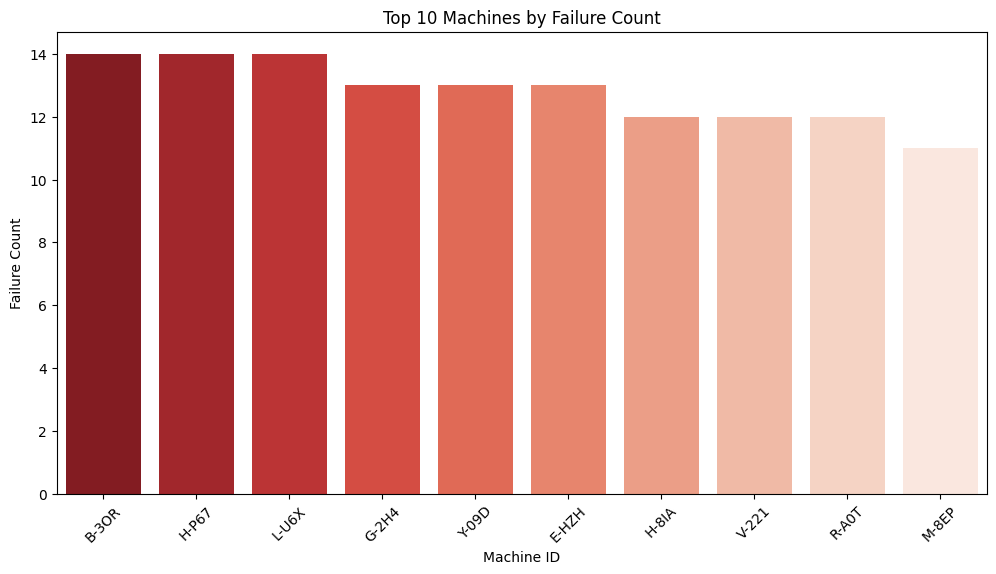

In [15]:
# Failure counts per machine
fail_counts = df.groupby('machine_id')['failure'].sum().sort_values(ascending=False).head(10)
plt.figure(figsize=(12,6))
sns.barplot(x=fail_counts.index, y=fail_counts.values, hue=fail_counts.index, palette='Reds_r', legend=False)
plt.title('Top 10 Machines by Failure Count')
plt.ylabel('Failure Count')
plt.xlabel('Machine ID')
plt.xticks(rotation=45)
plt.show()

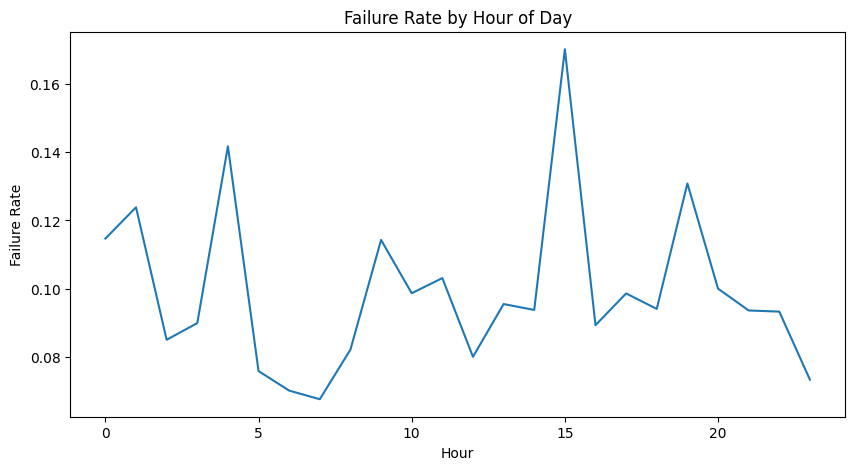

In [16]:
# Failure rate by hour of day
fail_by_hour = df.groupby('hour')['failure'].mean()
plt.figure(figsize=(10,5))
sns.lineplot(x=fail_by_hour.index, y=fail_by_hour.values)
plt.title('Failure Rate by Hour of Day')
plt.xlabel('Hour')
plt.ylabel('Failure Rate')
plt.show()

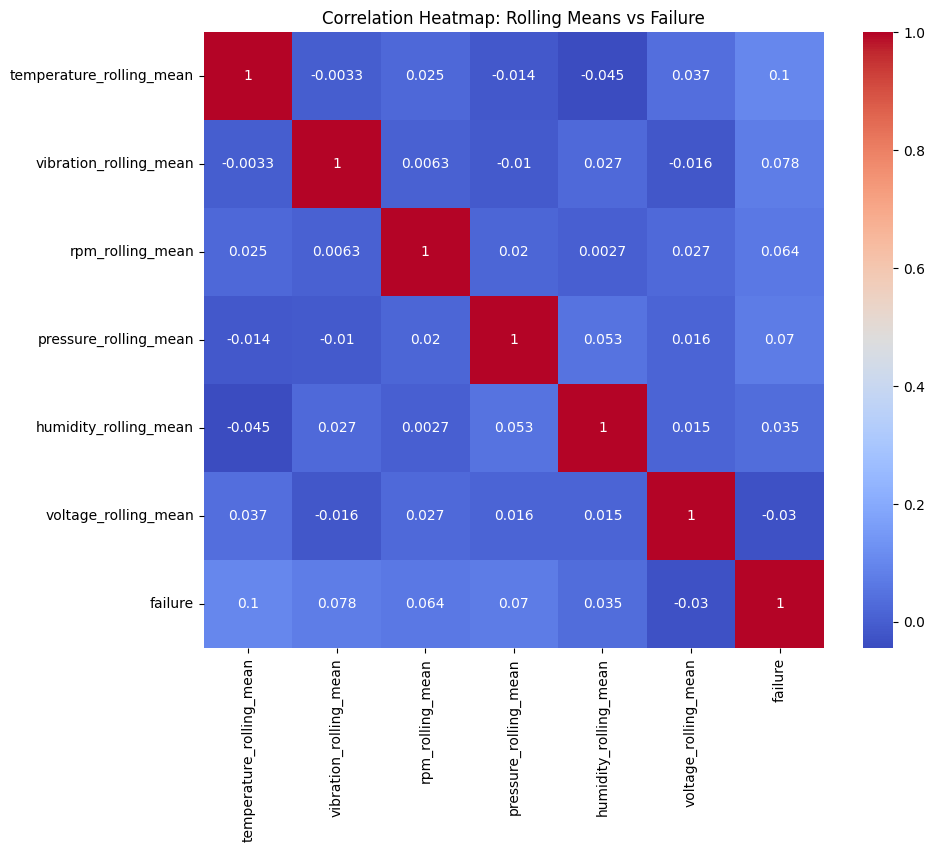

In [17]:
# Heatmap of correlations between rolling means and failure
corr_cols = [f'{feat}_rolling_mean' for feat in rolling_feats] + ['failure']
plt.figure(figsize=(10,8))
sns.heatmap(df[corr_cols].corr(), annot=True, cmap='coolwarm')
plt.title('Correlation Heatmap: Rolling Means vs Failure')
plt.show()

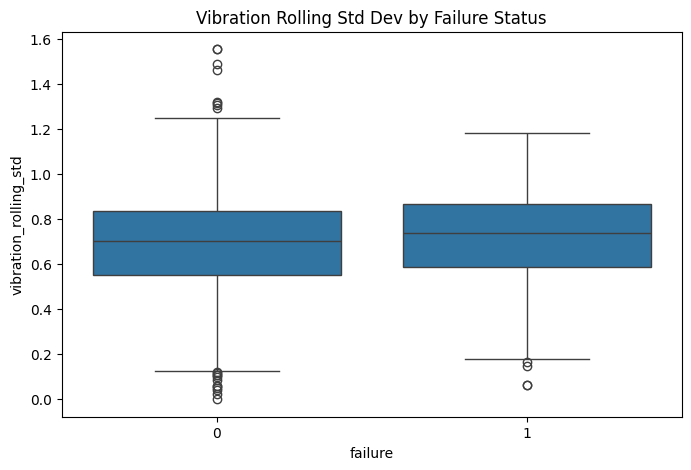

In [18]:
# Scatter plot: vibration rolling std vs failure
plt.figure(figsize=(8,5))
sns.boxplot(x='failure', y='vibration_rolling_std', data=df)
plt.title('Vibration Rolling Std Dev by Failure Status')
plt.show()

<ipython-input-19-55a7e0151e89>:2: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  monthly_failures = df.set_index('timestamp').resample('M')['failure'].sum()


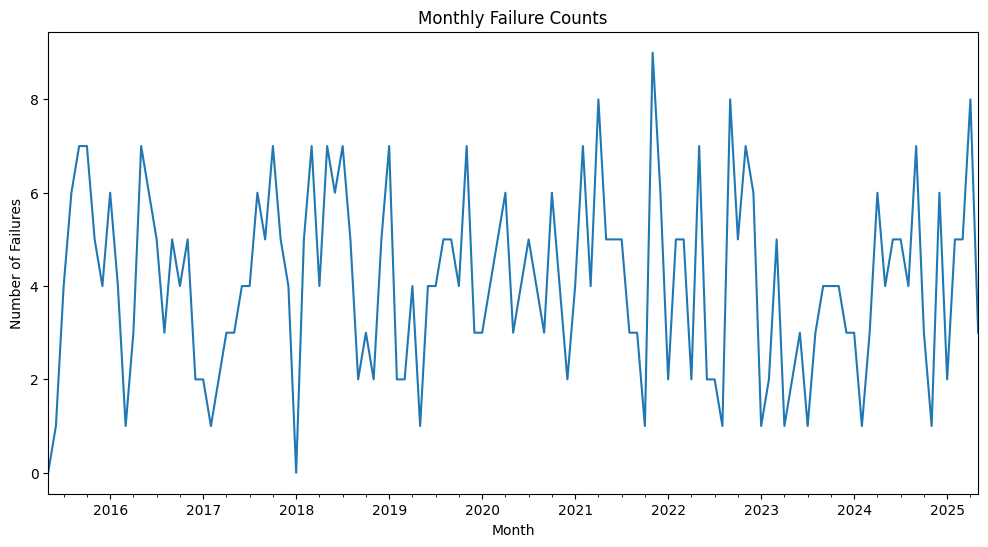

In [19]:
# Time series trend of failure counts monthly
monthly_failures = df.set_index('timestamp').resample('M')['failure'].sum()
plt.figure(figsize=(12,6))
monthly_failures.plot()
plt.title('Monthly Failure Counts')
plt.ylabel('Number of Failures')
plt.xlabel('Month')
plt.show()

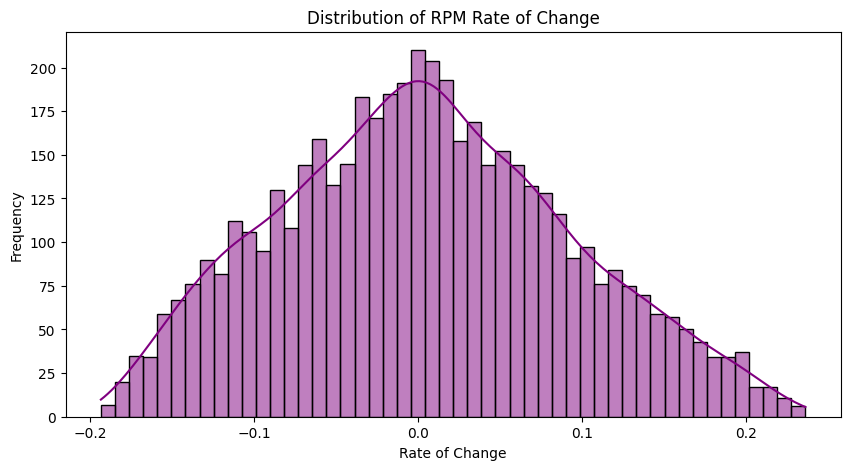

In [20]:
# Distribution of rate of change in RPM
plt.figure(figsize=(10,5))
sns.histplot(df['rpm_roc'].dropna(), bins=50, kde=True, color='purple')
plt.title('Distribution of RPM Rate of Change')
plt.xlabel('Rate of Change')
plt.ylabel('Frequency')
plt.show()

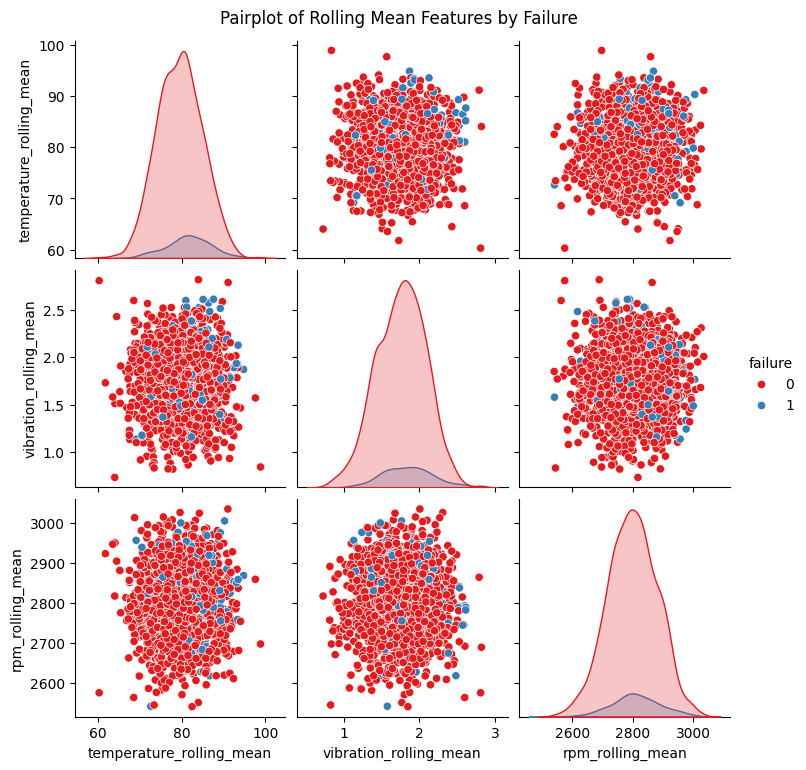

In [21]:
# Pairplot of key rolling mean features colored by failure
sns.pairplot(df.sample(2000), vars=[f'{feat}_rolling_mean' for feat in ['temperature', 'vibration', 'rpm']], hue='failure', palette='Set1')
plt.suptitle('Pairplot of Rolling Mean Features by Failure', y=1.02)
plt.show()

### Save processed data for modeling

In [22]:
df.to_json('/content/drive/MyDrive/SmartFactory/Dataset/processed_sensor_data.json', orient='records', date_format='iso')

print("Extended preprocessing and feature engineering complete.")
print("Processed data saved to 'processed_sensor_data_week2.json'")

Extended preprocessing and feature engineering complete.
Processed data saved to 'processed_sensor_data_week2.json'
